## ANLP Assignment 1: Sentiment Analysis
### Arpan Mukhopadhyay,  a1797378

In [547]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from langdetect import detect
import json
import re
from collections import Counter, defaultdict
import string
pd.options.mode.chained_assignment = None  # default='warn'

### 1. Reading dataset and initial pre-processing

Before any real visualisations or exploration of the data, the removal of any non english reviews is conducted using the function in language_filter.py.

In [548]:
#Cleaning out the original test and train datasets 
def langFilter(file,type:str):
    num = 0
    with open(f"hotel_review_en_{type}.JSON", "w") as out_file:
        with open(file,"r") as in_file:
            lines = in_file.readlines()
            for line in lines:
                num += 1
                # if num%100==0: print(num)
                json_line = json.loads(line)
                try:
                    lang = detect(json_line["text"])
                    if lang == "en":
                        out_file.write(line)
                except:
                    print("exception")
                    pass

#uncomment to generate JSON train and test sets of only english texts
# langFilter("hotel_reviews_train.JSON","train")
# langFilter("hotel_reviews_test.JSON","test")

We can see below that by applying the function on the training dataset, we removed a single non english review. We can also load in our json data as a pandas dataframe to make it easier to work with.

In [549]:
original_data = pd.read_json('hotel_reviews_train.JSON', lines=True)
train_data = pd.read_json("hotel_review_en_train.JSON", lines=True)

#checking to see the difference in reviews after removal of non english reviews
print(len(original_data))
print(len(train_data))

24000
23999


In [550]:
test_data = pd.read_json("hotel_review_en_test.JSON", lines=True)
print(len(test_data))

6000


With our data now in df format, we can begin to explore the formatting of what we are working with. Intially let's look at all the different components that make up a single "review"

In [551]:
train_data.columns

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile'],
      dtype='object')

Now let's have a closer look at how the title and text sections of our data is formated in our current dataset

In [552]:
train_data['title']

0                             “Horrible experience”
1                                       “Stay Away”
2                      “Great location and service”
3                “I will never go back here again!”
4        “Ripped off our VISA card after departure”
                            ...                    
23994            “pleasant stay with good location”
23995     “Hit or miss, some things need attention”
23996                              “Good breakfast”
23997                    “Deserves a higher rating”
23998                        “Clean & comfortable!”
Name: title, Length: 23999, dtype: object

In [553]:
train_data['text'][0]

'First of all we got there and they didn\'t have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\nWe thought by paying more we would get a good deal well this hotel is not the case!!\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own "policies" and undesirable customer service.\nGreat time in San Diego but a nightmare of a hotel.\nDon\'t ever write reviews but this one was called for, if you can avoid this hotel do it.\n(Being a military family and movin

We can see - especially in the text of our first review - that there are a number of non-alphanumeric characters (\'t, -, \n) that pepper the text. This could likely cause problems during evaluation as in the simplest terms, they add "noise" to our data. Our models and their respective tokenisers would also likely only expect alphanumeric representations. For more complex and dynamic tokenisation methods, the removal of these additional characters would reduce the overall vocab size and number of features which would make evaluation much less computationally intensive.

To do this, we clean the data using some basic regex commands. Non-alphanumeric characters were prioritised alongside newline characters and apostrophes. Additional white spaces were also cleaned while an additional english translation step was introduced as a final sanity check for the previous step.

While it should be noted that the removal of some of these characteristics may impact context clues, a more simplistic assumption is followed over the course of this assignment. Given an extention, experimentation could have been conducted regarding this. 

In [554]:
#omitting lowercase for now
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]','',text)
        text = re.sub(r'[\n\r\t]', ' ',text)
        text = re.sub(r'\s+', ' ', text)
        text.translate(text.maketrans('', '', string.punctuation)) #added just as a final sanity check if stuff was missed
        return text.strip()
    return ""

train_data['clean_title'] = train_data['title'].apply(clean_text)
train_data['clean_text'] = train_data['text'].apply(clean_text)

test_data['clean_title'] = test_data['title'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)

Now by comparing the original and clean text, we can verify that the text cleaning function worked.

In [555]:
train_data['text'][0]

'First of all we got there and they didn\'t have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\nWe thought by paying more we would get a good deal well this hotel is not the case!!\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own "policies" and undesirable customer service.\nGreat time in San Diego but a nightmare of a hotel.\nDon\'t ever write reviews but this one was called for, if you can avoid this hotel do it.\n(Being a military family and movin

In [556]:
train_data['clean_text'][0]

'First of all we got there and they didnt have the room we booked did not pay us the difference from the room we booked to the cheaper one they gave us STAFF took forever to address our problem not KID friendly pool dirty and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY We thought by paying more we would get a good deal well this hotel is not the case 400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business They are giving SHERATON a horrible reputation I guess they are managed by SHERATON but have their own policies and undesirable customer service Great time in San Diego but a nightmare of a hotel Dont ever write reviews but this one was called for if you can avoid this hotel do it Being a military family and moving from state to state we know

### 2. Exploratory Data Analysis (EDA)

Now following basic cleaning, we can start exploring the more telling sections of our dataset. We begin by verifying that the features for both the training and test set are identical

In [557]:
print(train_data.columns)
print(test_data.columns)

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')
Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')


Now we can have a better look at our dataset as a whole. From now on, all visualisations will almost exclusively be conducted on the training data

In [558]:
train_data.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
0,"{'service': 1.0, 'cleanliness': 2.0, 'overall'...",“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False,Horrible experience,First of all we got there and they didnt have ...
1,"{'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...",“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False,Stay Away,Found Racist graffiti in the room Request to c...
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,Great location and service,Close to Union Square hotel is a bit of a maze...
3,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...",“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,I will never go back here again,I had a bad vibe about this place from the mom...
4,{'overall': 1.0},“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,Ripped off our VISA card after departure,After we received our final bill and left the ...


Now given that the assignment specifies the evaluation features to be "overall", "title" and "text", we should check to see if there are any missing fields that we should omit from the data. It can be seen that the overall rating is contained within a dictionary of ratings so to see if any reviews dont have an overall rating, it's as simple as doing key lookups in a dictionary.

In [559]:
missing_overall_rating = train_data[~train_data['ratings'].apply(lambda x: 'overall' in x)]
missing_overall_rating

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text


By performing this key lookup, we can see that every single review in the dataset contains atleast an overall rating of some kind. This means we can continue on to both the text and title fields. 

To explore the properties of both the text and title fields, the easiet way would be to check the minimum, average and maximum lengths of their contents. The code for both checks is near identical with only the accessed column being different 

In [560]:
max_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).max()
mean_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).mean()
min_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).min()

print(f"Shortest review: {min_words} words", 
      f"\nAverage length of review: {round(mean_words,3)} words", 
      f"\nLongest review: {max_words} words")

Shortest review: 4 words 
Average length of review: 152.342 words 
Longest review: 2239 words


In [561]:
max_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).max()
mean_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).mean()
min_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).min()

print(f"Shortest review title: {min_title_length} words", 
      f"\nAverage length of review title: {round(mean_title_length ,3)} words", 
      f"\nLongest review title: {max_title_length} words")

Shortest review title: 0 words 
Average length of review title: 4.822 words 
Longest review title: 26 words


We notice here that while there seems to be text content for all the reviews in the dataset, there are titles present that have 0 words. Through exploration of the data, we can see that it seems to only be one review that lacks a title. We also see that this is a result of data cleaning as the original title contained a non-alphanumeric character.

In [562]:
row_data = train_data.loc[train_data['clean_title'].str.split().str.len() == 0]
row_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
2169,"{'service': 1.0, 'cleanliness': 5.0, 'overall'...","“!""”",We stayed in the W in Dallas twice. The first ...,"{'username': 'Chach63', 'num_cities': 15, 'num...",October 2011,600113,3,2012-07-06,133598143,False,,We stayed in the W in Dallas twice The first t...


 We make the decision to keep to keep this datapoint as text content of the review is still quite relavent and further down the line, both the title and text content will be combined into a singluar feature.

In [563]:
print(f"original title: {row_data['title'].iloc[0]},\ncleaned title: '{row_data['clean_title'].iloc[0]}' ")

original title: “!"”,
cleaned title: '' 


Now why dont we have a look at the longest title

In [564]:
row_data_max = train_data.loc[train_data['clean_title'].str.split().str.len() == 26]
row_data_max

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
5851,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...","“It was good hotel, a bit of walk to union squ...","It was good hotel, a bit of walk to union squa...","{'username': 'ECO_minnie', 'num_cities': 7, 'n...",January 2012,676408,0,2012-01-08,122776348,True,It was good hotel a bit of walk to union squar...,It was good hotel a bit of walk to union squar...


We notice here that the title of the review mirrors the text content of the review. This is an odd finding, could there be many more cases where this is the case?

In [565]:
# Here we check the number of titles that mirror the start of their reviews. Title length longer than 4 as shorter titles typically are just expressions and as such not really duplications
# For now we'll leave them as is but this could be an area of further research
row_data_dups = train_data.loc[
    train_data.apply( 
        lambda train: len(train['clean_title'].split()) > 4 and train['clean_text'].lower().startswith(train['clean_title'].lower()),
        axis = 1
        )
    ]

print(f"Number of reviews thats start with their entire title (title longer than 4 words): {len(row_data_dups)}")
row_data_dups

Number of reviews thats start with their entire title (title longer than 4 words): 43


,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
556,"{'service': 2.0, 'cleanliness': 1.0, 'overall'...",“Sorry to say i did not enjoy my stay at your ...,Sorry to say i did not enjoy my stay at your h...,"{'username': 'WYNONNA H', 'num_reviews': 1, 'i...",December 2012,73768,0,2012-12-10,147158092,False,Sorry to say i did not enjoy my stay at your h...,Sorry to say i did not enjoy my stay at your h...
3056,"{'service': 3.0, 'cleanliness': 3.0, 'overall'...",“Super Location/Tony the Tiger Breakfast (Grrr...,Super Location/Tony the Tiger Breakfast (Grrrr...,"{'username': 'TriciaSK', 'num_cities': 4, 'num...",January 2012,79977,1,2012-02-16,124670932,False,Super LocationTony the Tiger Breakfast Grrrreat,Super LocationTony the Tiger Breakfast Grrrrea...
3652,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“it is a very decent hotel and an excellent pl...,it is a very decent hotel and an excellent pla...,"{'username': 'BanuPradeep', 'num_reviews': 1, ...",December 2011,619615,1,2011-12-29,122221815,False,it is a very decent hotel and an excellent pla...,it is a very decent hotel and an excellent pla...
3832,"{'service': 1.0, 'cleanliness': 1.0, 'overall'...",“Worst hotel I've ever stayed in”,Worst hotel I've ever stayed in!! First I wait...,"{'username': 'Sk65stang', 'num_reviews': 3, 'n...",April 2012,108990,0,2012-04-24,128550978,True,Worst hotel Ive ever stayed in,Worst hotel Ive ever stayed in First I waited ...
3963,"{'service': 5.0, 'cleanliness': 4.0, 'overall'...","“Love stayiing at the New Yorker. However, thi...","Love stayiing at the New Yorker. However, this...","{'username': 'CLAIRE M', 'num_reviews': 1, 'id...",November 2012,122005,2,2012-11-30,146487223,False,Love stayiing at the New Yorker However this t...,Love stayiing at the New Yorker However this t...
4032,"{'service': 3.0, 'cleanliness': 4.0, 'overall'...",“Apparently being close to the University of T...,Apparently being close to the University of Te...,"{'username': 'RACHEL B', 'num_reviews': 1, 'id...",December 2012,608007,0,2012-12-10,147152684,False,Apparently being close to the University of Te...,Apparently being close to the University of Te...
4382,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“The Benjamin was absolutely brilliant, from t...","The Benjamin was absolutely brilliant, from th...","{'username': 'jimmy096', 'num_reviews': 1, 'id...",November 2010,217626,0,2010-12-19,90249199,False,The Benjamin was absolutely brilliant from the...,The Benjamin was absolutely brilliant from the...
5199,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Stayed here with my partner for several...”,Stayed here with my partner for several nights...,"{'username': 'nickntulsa', 'num_cities': 6, 'n...",August 2010,120058,0,2010-08-08,74239281,True,Stayed here with my partner for several,Stayed here with my partner for several nights...
5833,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Warm and friendly staff; great accommodations...,Warm and friendly staff; great accommodations;...,"{'username': 'rhonda_1204', 'num_reviews': 1, ...",January 2012,99007,0,2012-01-26,123676902,False,Warm and friendly staff great accommodations d...,Warm and friendly staff great accommodations d...
6225,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Wowowowowow Absolutely one of the amazing...”,Wowowowowow Absolutely one of the amazing stay...,"{'username': 'Jaddo', 'num_cities': 11, 'num_h...",August 2010,1502098,0,2010-08-23,76580951,True,Wowowowowow Absolutely one of the amazing,Wowowowowow Absolutely one of the amazing stay...


In [566]:
row_data = train_data[train_data['clean_title'].str.split().str.len() == 1]
row_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
15,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Value”,"Doing an AM tour at Sony Studios, and the loca...","{'username': 'rwmentzer', 'num_cities': 16, 'n...",September 2012,248239,0,2012-09-28,141497337,False,Value,Doing an AM tour at Sony Studios and the locat...
26,"{'service': 5.0, 'cleanliness': 4.0, 'overall'...",“Fairmont-Dallas”,We had a most enjoyable short stay at this fin...,"{'username': 'Fred H', 'num_reviews': 1, 'id':...",October 2012,98606,0,2012-10-21,143365025,False,FairmontDallas,We had a most enjoyable short stay at this fin...
37,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Excellent”,We had the misfortune of getting standed in Sa...,"{'username': 'NorthLincsChikky', 'num_cities':...",November 2009,79985,1,2009-11-08,48753878,False,Excellent,We had the misfortune of getting standed in Sa...
70,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",“wow”,"well, where to start? \nfirstly, the location,...","{'username': 'dexbrighton', 'num_cities': 2, '...",February 2007,93507,5,2007-02-19,6811836,False,wow,well where to start firstly the location that ...
85,"{'cleanliness': 5.0, 'value': 4.0, 'overall': ...",“Outstanding!”,Just back from a (2) day stay at the Omni. Aft...,"{'username': 'dje', 'num_cities': 10, 'num_hel...",May 2005,224948,7,2005-05-31,3514473,False,Outstanding,Just back from a 2 day stay at the Omni After ...
...,...,...,...,...,...,...,...,...,...,...,...,...
23799,{'overall': 2.0},“Sewage”,Unfortunately the room smelled like sewage. Ve...,"{'username': 'J W', 'num_reviews': 2, 'num_cit...",July 2012,87635,0,2012-07-20,134944668,False,Sewage,Unfortunately the room smelled like sewage Ver...
23806,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Exceptional”,In addition to it being about a three minute w...,"{'username': 'Layover', 'num_cities': 102, 'nu...",March 2009,1157456,1,2009-05-11,29788756,False,Exceptional,In addition to it being about a three minute w...
23820,"{'service': 2.0, 'cleanliness': 1.0, 'overall'...",“Horrible”,Room doors that look like coffin lids. Sea foa...,"{'username': 'spanlaketraveler', 'num_cities':...",December 2007,214197,2,2007-12-08,11326781,False,Horrible,Room doors that look like coffin lids Sea foam...
23954,"{'cleanliness': 1.0, 'overall': 1.0, 'rooms': ...",“Seedy”,I was surprised to learn from the other review...,"{'username': '', 'id': '', 'location': ''}",April 2005,100561,9,2005-04-08,3343889,False,Seedy,I was surprised to learn from the other review...


Although we have numerically analysed some properties of our review lengths, a better way to fully gauge the spread of our data would be through visualisations. We can start by graphing the spread of review lengths.

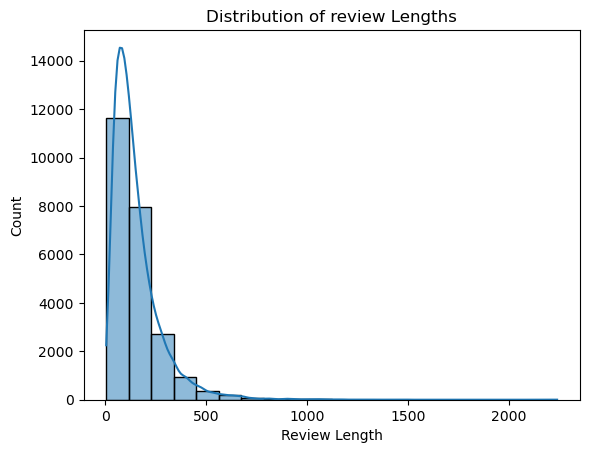

In [567]:
import seaborn as sns
train_data['text_length'] = train_data['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(train_data['text_length'], bins=20, kde=True)
plt.title('Distribution of review Lengths')
plt.xlabel('Review Length')
plt.show()

We can see here that our data in regards to review lengths is heavily imbalanced and gives us something akin to a right-skewed distribution. However, it seems that while there is a large spread of data, the actual number of reviews above approximately, 800 words doesnt seem to be very much. We can verify this assumption numerically. 

In [568]:
total_reviews = len(train_data)

reviews_upto_800 = len(train_data[train_data['clean_text'].str.split().str.len() <= 800])
ratio = reviews_upto_800 / total_reviews
percentage = ratio * 100

print(f"Number of reviews with <=800 words: {reviews_upto_800}")
print(f"Total number of reviews: {total_reviews}")
print(f"Percentage of reviews with <=800 words: {percentage:.2f}%")

Number of reviews with <=800 words: 23910
Total number of reviews: 23999
Percentage of reviews with <=800 words: 99.63%


We can see here that despite the large spread, 99.63% of all reviews are under 800 words with the rest shown on the graph being key outliers. Though this could potentially cause problems in regards to compute, it is assumed that most models, especially proficient deep learning models have in built truncation methods to minimise the effect of such outlandish data points. It is also assumed that enough of the key sentiment would be contained in the intiial few hundred words of those reviews. As such, they have been kept within the dataset. Code to remove them has been included if computational efficiency is preferred though it is expected that their removal would not affect performance too heavily. 

In [569]:
# train_data = train_data[train_data['clean_text'].str.split().str.len() <= 800].reset_index(drop=True)
# train_data['text_length'] = train_data['clean_text'].apply(lambda x: len(x.split()))
# sns.histplot(train_data['text_length'], bins=20, kde=True)
# plt.title('Distribution of review Lengths')
# plt.xlabel('Review Length')
# plt.show()

We perform the same visuation on title lengths as shown below and while still right-skewed, indicates a much less extreme distribution and presence of outliers. 

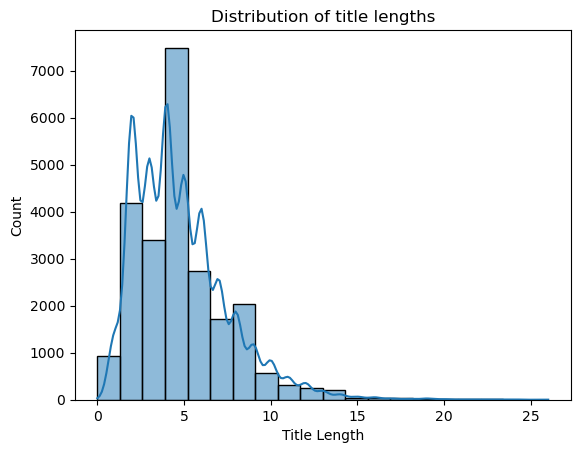

In [570]:
train_data['title_length'] = train_data['clean_title'].apply(lambda x: len(x.split()))
sns.histplot(train_data['title_length'], bins=20, kde=True)
plt.title('Distribution of title lengths')
plt.xlabel('Title Length')
plt.show()

Following the visual analysis of textual content, we can visualise the distribution of the values taken by the "overall" ratings. The visualisation and understanding of the data here is crucial as this is our primary predictive label. While variety and outliers in our features provides points of interest, issues with our classes could cause large problems down the line if not identified early. As such, two different visualisation types were exercised to best understand the distribution and variation of labels. A bar graph to illustrate the quantitative range of the labels and a pie chart to show the percentage breakdown of each class.

[(5, 9824), (4, 7720), (3, 3287), (2, 1611), (1, 1557)]


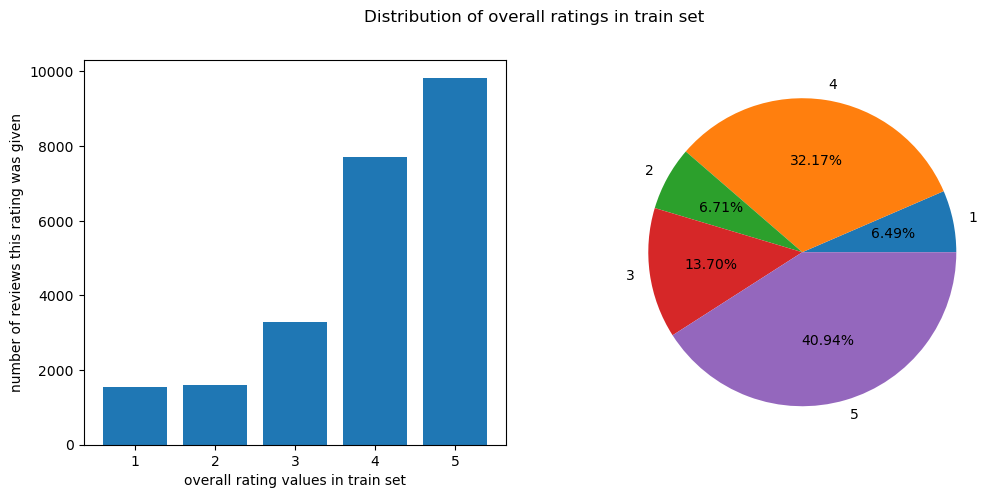

In [571]:
def overall_ratings_plot(data, type):
    ratings_distribution = []
    for i in range(len(data)):
        ratings_distribution.append(int(train_data['ratings'][i]['overall']))
    ratings_freq = Counter(ratings_distribution)
    print(sorted(ratings_freq.items(), key= lambda x:x[0], reverse=True))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Distribution of overall ratings in {type} set')
    axes[0].bar(ratings_freq.keys(), ratings_freq.values())
    axes[0].set_xlabel(f'overall rating values in {type} set')
    axes[0].set_ylabel('number of reviews this rating was given')

    axes[1].pie (ratings_freq.values(), labels= ratings_freq.keys(), autopct='%1.2f%%')

overall_ratings_plot(train_data, 'train')

From both visualisations it becomes quite evident that the dataset contains a very large imbalance between labels. Class imbalance is a large talking point in data analysis and machine learning as given improper care, it could lead to models showing bias towards the classes with more data points and hence generalising better towards them and performing worse against classes with lesser data points. In our case, given the current distribution, we can see that positive reviews (4,5 star) make up 73.11% of the data. This is a distribution that becomes especially more problematic when we consider how our model may approach the classification of texts into classes 1,2,3. Especially when considering the notion that "neutral" emotions tend to be the most difficult to classify. Further discussion on class imbalance will be conducted in the machine learning models section.

As a further sanity check, we see if the distribution of labels in the test set is akin to that in the training set. 

[(5, 2509), (4, 1888), (3, 828), (2, 408), (1, 367)]


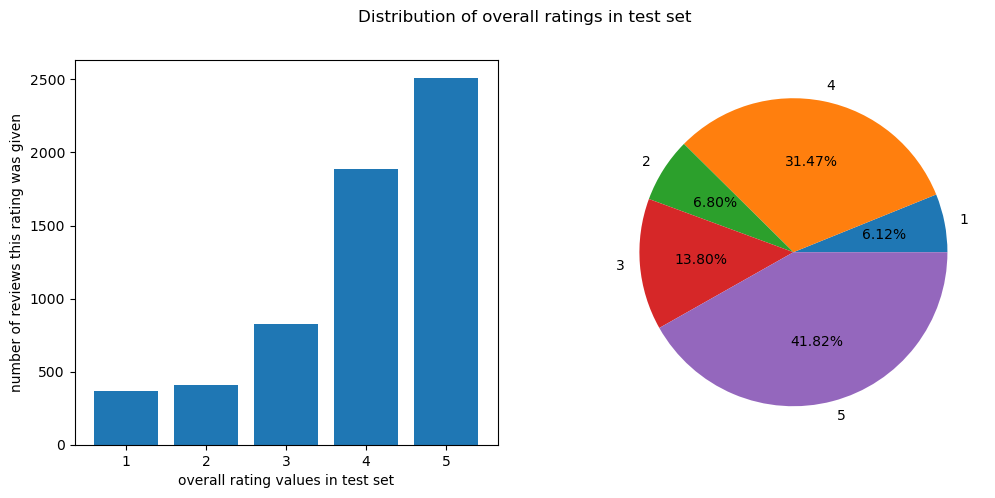

In [572]:
overall_ratings_plot(test_data, 'test')

As shown above, we can see that while not exactly identical to the train set in regards to distribution, the test set very closely mirrors it. This bodes well for future experiments.

Following the visualisation and analysis of the more general components of our features and labels, it makes sense to now visualise and analyse the differences between some potential transformations that could be applied to the data to see which seem to work best. We can do so by comparing the difference between the clean, stemmed and lemmatized version of some of our texts

In [573]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
train_data['stemmed_text'] = train_data['clean_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
train_data['stemmed_text']

0        first of all we got there and they didnt have ...
1        found racist graffiti in the room request to c...
2        close to union squar hotel is a bit of a maze ...
3        i had a bad vibe about thi place from the mome...
4        after we receiv our final bill and left the em...
                               ...                        
23994    we stay just one night here when visit our son...
23995    spent two night here with spous in conjunct wi...
23996    the room wa fairli larg pretti quiet the bed w...
23997    great start to our stay when we were check in ...
23998    great room comfort bed food is good the locat ...
Name: stemmed_text, Length: 23999, dtype: object

In [574]:
import spacy
# !python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

#Noting: Lemmatization takes a while to run so running through pipe to speed it up (still takes ~2 mins)
def lemmatize(text):
    docs = list(nlp.pipe(text))
    return [' '.join([token.lemma_ for token in doc]) for doc in docs]

train_data['lemmatized_text'] = lemmatize(train_data['clean_text'])
train_data['lemmatized_text']

0        first of all we get there and they do not have...
1        find Racist graffiti in the room request to ch...
2        close to Union Square hotel be a bit of a maze...
3        I have a bad vibe about this place from the mo...
4        after we receive our final bill and leave the ...
                               ...                        
23994    we stay just one night here when visit our son...
23995    spend two night here with spouse in conjunctio...
23996    the room be fairly large pretty quiet the bed ...
23997    great start to our stay when we be check in 2h...
23998    great room comfortable bed food be good the lo...
Name: lemmatized_text, Length: 23999, dtype: object

In [575]:
a1 = train_data['stemmed_text'][4].split()
a2 = train_data['lemmatized_text'][4].split()
a3 = train_data['clean_text'][4].split()

print("Original Word | Stemmed Form | Lemmatized Form")
print("-" * 50)

for orig, stem, lemma in zip(a3, a1, a2):
    if stem != lemma:
        print(f"{orig:<13} | {stem:<12} | {lemma:<12}")


Original Word | Stemmed Form | Lemmatized Form
--------------------------------------------------
received      | receiv       | receive     
left          | left         | leave       
Empire        | empir        | Empire      
another       | anoth        | another     
charge        | charg        | charge      
accounting    | account      | accounting  
sent          | sent         | send        
justification | justif       | justification
response      | respons      | response    
company       | compani      | company     


Using this table we can best compare how stemming and lemmatization differ from both each other and the original cleaned text. The idea behind stemming and lemmatization is once again to reduce to number of features present within the text and simplify them to their core forms. Although as we can see here, they approach this same problem in different ways. While stemming reduces words into their "stems" (the core meaning-bearing units of a word), lemmatization reduces the word to its base form. 

And while both have their benefits, just from this table alone we can see that while stemming transforms the word into occasionally odd word forms, lemmatization converst the words into base forms that are still real words. This is because it reduces the word to its dictionary form and as a result essentially helps preserve almost full contextual and sentiment meaning. This is a feature that makes it especially good for our sentiment analysis taks. As a result, lemmatization was the transformation of choice for both visualisations and models moving forward. 

Moving forward, we can start looking at the spread of individual words in our dataset to begin a brief exploration into how these reveiws are written and if certian words may potentially indicate certain sentiments.

In [576]:
unique_words = set()
all_words = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    for w in data:
        unique_words.add(w)
        all_words.append(w)

#vocab size of 62505 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

#Note these are all stop words so should probably prune the dataset for stop words before looking for most common words
fdist = FreqDist(all_words)
fdist.most_common(10)

number of unique words: 62505


[('the', 192545),
 ('and', 127800),
 ('a', 103769),
 ('to', 93843),
 ('was', 80158),
 ('I', 59749),
 ('in', 57570),
 ('of', 50150),
 ('The', 47904),
 ('is', 46002)]

Now lets see if the distribution of the most common words differs following lemmatization of the text

In [577]:
unique_words = set()
all_words = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    for w in data:
        unique_words.add(w)
        all_words.append(w)

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

#Note these are all stop words so should probably prune the dataset for stop words before looking for most common words
fdist = FreqDist(all_words)
fdist.most_common(10)

number of unique words: 54072


[('the', 240655),
 ('be', 199451),
 ('and', 129430),
 ('a', 106050),
 ('to', 94381),
 ('I', 73297),
 ('we', 61408),
 ('in', 59098),
 ('of', 50357),
 ('room', 46906)]

Seems to more or less the same. The problem could be we're including stop words in our analysis. It makes sense for stop words to be the most common words in our reviews as they typically act as "joining" words and almost all reviews and sentences contain them. In our following analysis, we conduct the same tests but this time without considering stop words

In [578]:
unique_words = set()
most_frequent_words = defaultdict(int)
for i in range(len(train_data)):
    data = train_data['lemmatized_text'][i].split()
    for w in data:
        unique_words.add(w)
        most_frequent_words[w] += 1

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

most_freq = sorted(most_frequent_words.items(), key=lambda x: x[1], reverse=True)
print(f"most frequent words use in reviews: {most_freq[:10]}") #Notice how all of them are stop words --> dataset needs pruning

number of unique words: 54071
most frequent words use in reviews: [('the', 240655), ('be', 199451), ('and', 129430), ('a', 106050), ('to', 94381), ('I', 73297), ('we', 61408), ('in', 59098), ('of', 50357), ('room', 46906)]


In [579]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def most_common_words(N:list):
    most_frequent_actual_words = []

    for n in N:
        if n[0].lower() not in stop_words:
            most_frequent_actual_words.append(n)
        if len(most_frequent_actual_words) == 10:
            break

    return most_frequent_actual_words

most_frequent_actual_words = most_common_words(most_freq)
most_frequent_actual_words

[('room', 46906),
 ('hotel', 43971),
 ('stay', 29283),
 ('great', 15991),
 ('would', 14202),
 ('staff', 14182),
 ('get', 13934),
 ('good', 13909),
 ('night', 12544),
 ('nice', 11574)]

Nice we can now see the most common words across all the reviews. We can now graph these using a bar graph to get a visual representation of just how often these words appear.

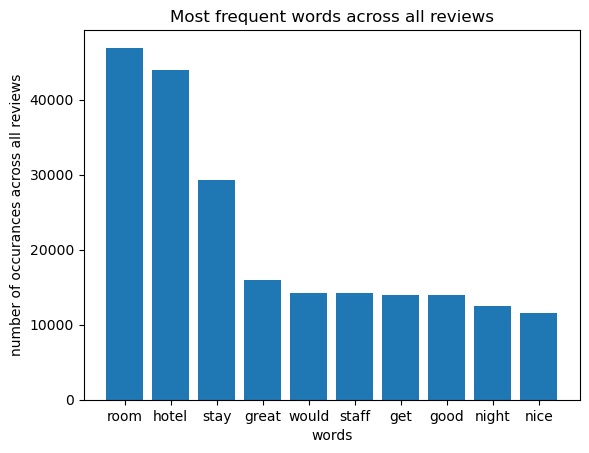

In [580]:
def plot_words(words, title_text, y_axis_text):
    words, counts = zip(*words)
    plt.bar(words, counts)
    plt.xlabel('words')
    plt.ylabel(y_axis_text)
    plt.title(title_text)

plot_words(most_frequent_actual_words,'Most frequent words across all reviews', 'number of occurances across all reviews')

Now this alone doesn't really help us too much. Most of these words seem to either be about rooms, the hotel, or words that typically carry positive sentiment (likely due to the very large class imbalance). Why dont we try zooming in a little more and try gauge the most common words present in both negative and positive reviews.

In [ ]:
def most_common_words_sentiment(N:list):
    negative_words = []
    positive_words = []
    for i in range(len(N)):
        data = word_tokenize(N['lemmatized_text'][i])
        rating = int(N['ratings'][i]['overall'])
        for w in data:
            if w.lower() in stop_words: continue
            #This is slightly problematic as it considers any rating >= 3 as positive. However we shall persist for simplicities sake.
            if rating >= 2.5: 
                positive_words.append(w)
            else:
                negative_words.append(w)
    
    return Counter(positive_words), Counter(negative_words)

positive_review_words, negative_review_words = most_common_words_sentiment(train_data)

print("Most common words in positive reviews: ")
positive_review_words.most_common(10)

Most common words in positive reviews: 


[('room', 37980),
 ('hotel', 37308),
 ('stay', 25099),
 ('great', 15312),
 ('staff', 12721),
 ('good', 12563),
 ('would', 11400),
 ('get', 11059),
 ('nice', 10615),
 ('night', 10108)]

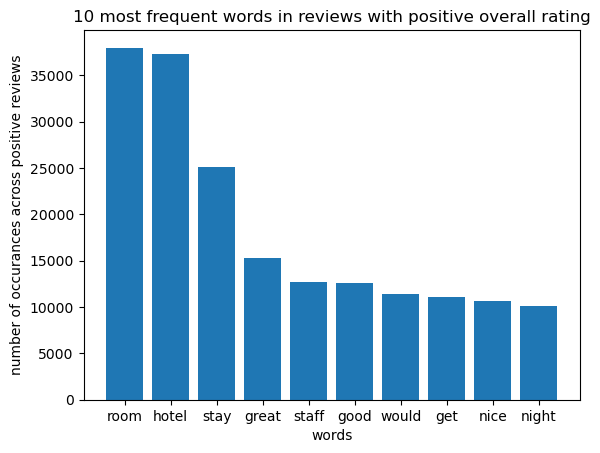

In [582]:
plot_words(positive_review_words.most_common(10),'10 most frequent words in reviews with positive overall rating', 'number of occurances across positive reviews')

In [583]:
print("Most common words in negative reviews:")
negative_review_words.most_common(10)

Most common words in negative reviews:


[('room', 8926),
 ('hotel', 6663),
 ('stay', 4184),
 ('get', 2875),
 ('would', 2802),
 ('night', 2436),
 ('one', 2234),
 ('go', 2135),
 ('say', 1694),
 ('could', 1663)]

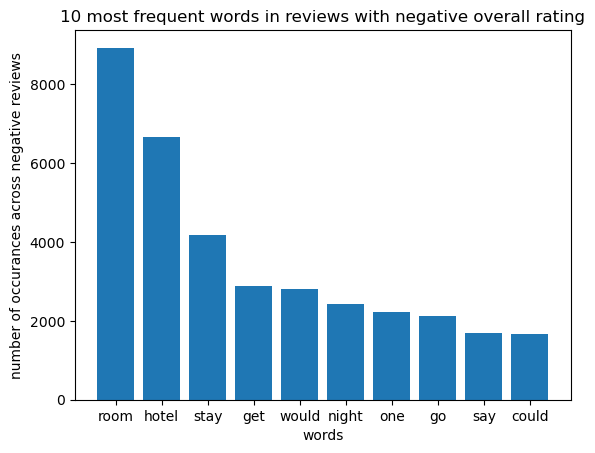

In [584]:
plot_words(negative_review_words.most_common(10),'10 most frequent words in reviews with negative overall rating', 'number of occurances across negative reviews')

We see here that even after looking at the words that appear most comononly in both positive and negative reveiws, we really dont know much about what differentiates both types of reviews. The most notable difference, (apart from the word counts which are naturally higher for the positive words) is the presence of the words "great", "good", "nice" in the most common positive reveiws. This makes sense in regards to sentiment, which shows that the partititon of reviews is likely accurate.

But while it does seem interesting to look at the most common words for both positive and negative reviews, we can go even further. Rather than just words, we can examine the most common "n-grams" present in both the text as a whole and alongside positive and negative reviews. These n-grams can give a better understanding of the most common phrases and combination of words within certain reviews and give us a visual and quantiative understanding of them. As a baseline, we will be using tri-grams as our basis for analysis as they seem to strike the best middle ground in terms of content and length.

We will calculate the most common n-grams for both the clean_text variants and the lemmatized variants of the reviews. 

In [585]:
from nltk import ngrams
n = 3
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

n_grams_list = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    n_grams = generate_ngrams(data, n)
    for gram in n_grams:
        n_grams_list.append(gram)

n_gram_freq = Counter(n_grams_list)

print(f"Distribution of {n}-grams:")
for ngram, count in n_gram_freq.most_common(10):
    print(f"{ngram}: {count}")

Distribution of 3-grams:
The room was: 2943
the front desk: 2927
in the room: 2192
of the hotel: 2064
The hotel is: 2030
stay here again: 1696
stayed at the: 1606
at this hotel: 1601
the room was: 1563
one of the: 1483


In [586]:
n = 3
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

n_grams_list = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    n_grams = generate_ngrams(data, n)
    for gram in n_grams:
        n_grams_list.append(gram)

n_gram_freq = Counter(n_grams_list)

print(f"Distribution of {n}-grams:")
for ngram, count in n_gram_freq.most_common(10):
    print(f"{ngram}: {count}")

Distribution of 3-grams:
the room be: 8638
the hotel be: 5439
the staff be: 4235
the front desk: 3637
stay at the: 3604
there be a: 3396
I do not: 2708
in the room: 2601
it be a: 2554
this hotel be: 2375


The most common tri-grams for all the reviews don't seem to be very useful as they seem to just be joining statements. What if we look at the most common tri grams for both "positive" and negative reviews?


In [ ]:
#positive and negative n-grams using the primary clean text corpus
positive_ngrams = []
negative_ngrams = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    n_grams = generate_ngrams(data, n)
    rating = int(train_data['ratings'][i]['overall'])
    if rating >= 2.5:
        for gram in n_grams:
            positive_ngrams.append(gram)
    else:
        for gram in n_grams:
            negative_ngrams.append(gram)

positive_ngrams_freq = Counter(positive_ngrams)
negative_ngrams_freq = Counter(negative_ngrams)

print(f"Most common {n}-grams for positive rating reviews:")
for ngram, count in positive_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")
print('\n')
print(f"Most common {n}-grams for negative rating reviews:")
for ngram, count in negative_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")


Most common 3-grams for positive rating reviews:
The room was: 2657
the front desk: 2047
The hotel is: 1894
of the hotel: 1777
in the room: 1680
stay here again: 1566
stayed at the: 1447
at this hotel: 1315
the room was: 1297
and it was: 1279


Most common 3-grams for negative rating reviews:
the front desk: 880
in the room: 512
of the hotel: 287
The room was: 286
at this hotel: 286
I had to: 267
the room was: 266
to the front: 223
we had to: 213
one of the: 209


In [ ]:
#positive and negative ngrams using the lemmatized text corpus
positive_ngrams = []
negative_ngrams = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    n_grams = generate_ngrams(data, n)
    rating = int(train_data['ratings'][i]['overall'])
    if rating >= 2.5:
        for gram in n_grams:
            positive_ngrams.append(gram)
    else:
        for gram in n_grams:
            negative_ngrams.append(gram)

positive_ngrams_freq = Counter(positive_ngrams)
negative_ngrams_freq = Counter(negative_ngrams)

print(f"Most common {n}-grams for positive rating reviews:")
for ngram, count in positive_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")
print('\n')
print(f"Most common {n}-grams for negative rating reviews:")
for ngram, count in negative_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")


Most common 3-grams for positive rating reviews:
the room be: 7601
the hotel be: 4880
the staff be: 3954
stay at the: 3201
there be a: 2936
the front desk: 2645
it be a: 2275
the location be: 2158
I do not: 2093
in the room: 2012


Most common 3-grams for negative rating reviews:
the room be: 1037
the front desk: 992
I do not: 615
in the room: 589
the hotel be: 559
there be no: 534
there be a: 460
stay at the: 403
this hotel be: 374
I have to: 343


Oddly enough, we see that the tri-grams for both positive and negative reviews are very similar. We can see below in the frequency bar grpahs for tri-grams in positive and negative reviews, that even their distributions are quite similar. This is a strange finding. But while this does not exactly answer the question regarding specific differences positive and negative reviews, it does show us that the most prevalent perdictive terms for most of these sequences are stop words. While it could be argued that their presence removes more meaningful sentiment carrying terms, it can be argued that they are the best predictors of other words which hence leads to unique contexts and unique sentiments. 

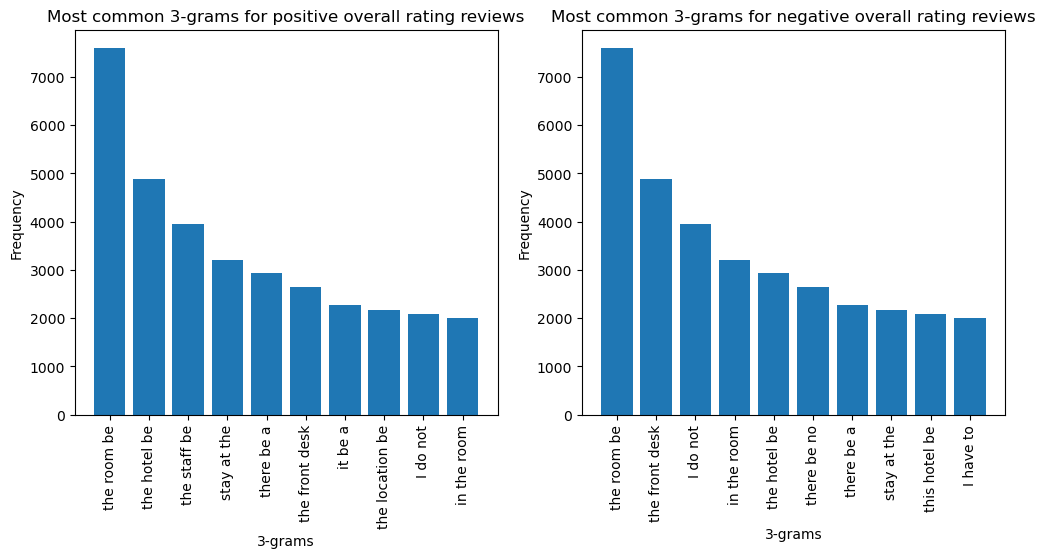

In [589]:
labels_pos, values_pos = zip(*positive_ngrams_freq.most_common(10))
labels_neg, values_neg = zip(*negative_ngrams_freq.most_common(10))
indexes = range(len(labels_pos))

lables = [labels_pos, labels_neg]
values = [values_pos, values_pos]

titles = [f"Most common {n}-grams for positive overall rating reviews", f"Most common {n}-grams for negative overall rating reviews"]
def multi_graph(indexes, labels, values, count, titles):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(count):
        axes[i].bar(indexes, values[i])
        axes[i].set_xlabel(f'{n}-grams')
        axes[i].set_ylabel('Frequency')
        axes[i].set_xticks(indexes, labels[i], rotation='vertical')
        axes[i].set_title(titles[i])

multi_graph(indexes, lables, values, 2, titles)

We can now perform similar visualisations on the titles

In [590]:
titles = train_data['clean_title']
title_words = []
for n in train_data['clean_title']:
    title = word_tokenize(n)
    for w in title:
        title_words.append(w.lower())

print(Counter(title_words).most_common(10))

[('great', 5981), ('hotel', 5185), ('location', 3992), ('the', 3191), ('a', 3067), ('and', 2669), ('stay', 2617), ('in', 2119), ('good', 2096), ('for', 1984)]


In [591]:
title_words_ns = []
for n in train_data['clean_title']:
    title = word_tokenize(n)
    for w in title:
        if w.lower() not in stop_words:
            title_words_ns.append(w.lower())
            
print(Counter(title_words_ns).most_common(10))

[('great', 5981), ('hotel', 5185), ('location', 3992), ('stay', 2617), ('good', 2096), ('nice', 1662), ('service', 1402), ('staff', 1118), ('excellent', 1081), ('place', 1079)]


Based off all these experiments, it becomes apparent that some additional changes must be made to the data before being fed into a machine learning model. Given the consistant requirement of lowercasing the words for both the title and the text, all the text should be normalised through lowercasing. Though this might remove some of the "textual emotion" conveyed in some of the reviews as capital letters could indicate both excitement and anger. But also these are not terribly useful considering how similar the good and the bad reviews seem to be in terms of word similar. So rather than frequency or even n-gram maybe we need to look deeper

### 3. Selection and training Machine Learning models

To prepare the dataset for machine learning, we must collate all the necessary fields into their own dataset. This process includes lowercasing the text and creating a dataset with columns containing the textual content of the review and its corresponding rating. As stated earlier, lemmatization will be the pre-processing technique of choice.

In [592]:
train_data['lemmatized_text'] = train_data['lemmatized_text'].apply(lambda x: x.lower())
train_data['clean_title'] = train_data['clean_title'].apply(lambda x: x.lower())

In [593]:
train_data['clean_title'] = lemmatize(train_data['clean_title'])

In [ ]:
#Function to extract the "overall" from the ratings dictionary of every review -> Convert to int from float
def get_overall(ratings):
    try:
        return int(ratings.get('overall',None))
    except(AttributeError, TypeError):
        return None

train_data['overall'] = train_data['ratings'].apply(get_overall)
train_data['overall']

0        1
1        1
2        4
3        2
4        1
        ..
23994    4
23995    3
23996    5
23997    4
23998    5
Name: overall, Length: 23999, dtype: int64

In [ ]:
#combining the rating, title and text into one dataframe to make it best suited for machine learning
lem_train_data_cur = train_data[['overall', 'clean_title','lemmatized_text']]

In [596]:
lem_train_data_cur

,overall,clean_title,lemmatized_text
0,1,horrible experience,first of all we get there and they do not have...
1,1,stay away,find racist graffiti in the room request to ch...
2,4,great location and service,close to union square hotel be a bit of a maze...
3,2,I will never go back here again,i have a bad vibe about this place from the mo...
4,1,rip off our visa card after departure,after we receive our final bill and leave the ...
...,...,...,...
23994,4,pleasant stay with good location,we stay just one night here when visit our son...
23995,3,hit or miss some thing need attention,spend two night here with spouse in conjunctio...
23996,5,good breakfast,the room be fairly large pretty quiet the bed ...
23997,4,deserve a high rating,great start to our stay when we be check in 2h...


Though there could have been many methods in regards to using the title and text as features, the easiest route was chosen and both were combined in to a single feature.

In [597]:
lem_train_data_cur['combined'] = lem_train_data_cur['clean_title'] + ' ' + lem_train_data_cur['lemmatized_text']
lem_train_data_cur

,overall,clean_title,lemmatized_text,combined
0,1,horrible experience,first of all we get there and they do not have...,horrible experience first of all we get there ...
1,1,stay away,find racist graffiti in the room request to ch...,stay away find racist graffiti in the room req...
2,4,great location and service,close to union square hotel be a bit of a maze...,great location and service close to union squa...
3,2,I will never go back here again,i have a bad vibe about this place from the mo...,I will never go back here again i have a bad v...
4,1,rip off our visa card after departure,after we receive our final bill and leave the ...,rip off our visa card after departure after we...
...,...,...,...,...
23994,4,pleasant stay with good location,we stay just one night here when visit our son...,pleasant stay with good location we stay just ...
23995,3,hit or miss some thing need attention,spend two night here with spouse in conjunctio...,hit or miss some thing need attention spend tw...
23996,5,good breakfast,the room be fairly large pretty quiet the bed ...,good breakfast the room be fairly large pretty...
23997,4,deserve a high rating,great start to our stay when we be check in 2h...,deserve a high rating great start to our stay ...


In [598]:
print(lem_train_data_cur['combined'])

0        horrible experience first of all we get there ...
1        stay away find racist graffiti in the room req...
2        great location and service close to union squa...
3        I will never go back here again i have a bad v...
4        rip off our visa card after departure after we...
                               ...                        
23994    pleasant stay with good location we stay just ...
23995    hit or miss some thing need attention spend tw...
23996    good breakfast the room be fairly large pretty...
23997    deserve a high rating great start to our stay ...
23998    clean comfortable great room comfortable bed f...
Name: combined, Length: 23999, dtype: object


Here is the final dataset that would be used for almost all of the machine learning work going forward. By simplifying the problem we now essentially have one input (combined block of text containing both the title and review) and one label (overall rating).

In [599]:
lem_train_data = lem_train_data_cur[['overall', 'combined']]
lem_train_data

,overall,combined
0,1,horrible experience first of all we get there ...
1,1,stay away find racist graffiti in the room req...
2,4,great location and service close to union squa...
3,2,I will never go back here again i have a bad v...
4,1,rip off our visa card after departure after we...
...,...,...
23994,4,pleasant stay with good location we stay just ...
23995,3,hit or miss some thing need attention spend tw...
23996,5,good breakfast the room be fairly large pretty...
23997,4,deserve a high rating great start to our stay ...


Final sanity checks before model work

In [600]:
lem_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   overall   23999 non-null  int64 
 1   combined  23999 non-null  object
dtypes: int64(1), object(1)
memory usage: 375.1+ KB


In [601]:
duplicate = lem_train_data.duplicated()
duplicate

0        False
1        False
2        False
3        False
4        False
         ...  
23994    False
23995    False
23996    False
23997    False
23998    False
Length: 23999, dtype: bool

In [ ]:
#Dropping duplicate found during analysis
lem_train_data.drop_duplicates(inplace=True)
lem_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23998 entries, 0 to 23998
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   overall   23998 non-null  int64 
 1   combined  23998 non-null  object
dtypes: int64(1), object(1)
memory usage: 562.5+ KB


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, mean_absolute_error, confusion_matrix

#Data broken up into a 90:10 split between training and test set. We can consider the test set in this case as esentially be a validation set
class_counts = Counter(lem_train_data['overall'])
X_train, X_test, y_train, y_test = train_test_split(lem_train_data["combined"], 
                                                    lem_train_data["overall"], 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    shuffle=True)
print(len(X_train), len(X_test))

print("class counts")
for k,v in class_counts.items():
    print(f'{k} : {v}')

21598 2400
class counts
1 : 1557
4 : 7720
2 : 1611
3 : 3287
5 : 9823


In [607]:
def eval_metrics(y_t, y_pred, model_name):
    mae = mean_absolute_error(y_t, y_pred)
    acc = accuracy_score(y_t, y_pred)
    weighted_f1 = f1_score(y_t, y_pred, average='weighted')
    macro_f1 = f1_score(y_t, y_pred, average='macro')

    print(f"{model_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 score: {weighted_f1:.4f}")
    print(f"F1 macro score: {macro_f1:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(classification_report(y_t, y_pred))

    con_mat = confusion_matrix(y_t, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(1, 6),
                yticklabels=range(1, 6))
    plt.xlabel('Predicted Rating')
    plt.ylabel('True Rating')
    plt.title('Confusion Matrix')
    plt.show()

Here we have chosen to go with TF-IDF as the vectorisation method of choice. Unlike count vectorisation, which just counts the frequency of words, TF-IDF assigns scores to words based on the term frequency in a document and the inverse document frequency across the entire corpus. This helps reduce the influence of commonly occurring words (counters the choice to include stop words in the text) and puts more importance on words that are informative for each review. Which for a sentiment classification task seems more ideal. This was further verified through experiments across multiple models.

While word embeddings were considered, and would have likely provided more nuanced results, embedding models like GloVe and Word2Vec were not used due to techincal difficulties with the virtual environment.

In [609]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=70000, min_df=5, max_df=0.8)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Logistic Regression was the model that performed best after much testing. While it was initially expected that the SVM would perform best due to its ability to deal with high dimensional data (like text) very well, Logistic regression with l2 regularisation managed to out perform it over a number of test runs. One way to understand why Logistic Regression outperformed the expected SVM (Hsu, 2020) here is to look at how they compute their results. As Logistic Regression computes outputs using the softmax activation function, it naturally has a better pre-disposition to a multi-class classification problem like this as it applies probabilities to each class on each output. In comparison SVM's operate on a one versus many approach for each class which could lead to inconsistencies when trying to classify ratings that veer into sentiment the gray zone (neutral or neutral adjacent ratings). Though it is assumed that through finer tuning, the SVM could likely out perform Logistic Regression. Further notes regarding SVM are also present in the reflection.

We should note here that class_weight was set to balanced to deal with the heavily imbalanced dataset. While resampling techniques such as SMOTE (Chawla et al.,2002) were tested, primarily on models like Multinomial Naive Bayes, it was found that using the inbuilt class balancing parameters of these models provided the best results. 

For model evaluation, a weighted F1 score was chosen to account for the imbalanced dataset. While accuracy measures the raw number of correct predictions the model is making, the F1 score is the harmonic mean of precision and recall, offering a more balanced assessment of performance. The weighted F1 score assigns each class a weight proportional to its frequency, thereby adjusting the overall score Macro F1 score is also considered, which treats all classes as equal. While all three metrics are visualised, consider the weighted F1 score to be the key metric. 

Alongside this, a confusion matrix accompanies the models for a more comprehensive look at model performance and the exact correct and incorrect classifications.

Normal Logistic Regression
Accuracy: 0.6404
F1 score: 0.6350
F1 macro score: 0.5767
Mean Absolute Error: 0.4146
              precision    recall  f1-score   support

           1       0.63      0.76      0.69       162
           2       0.33      0.31      0.32       147
           3       0.58      0.51      0.54       358
           4       0.60      0.55      0.58       774
           5       0.72      0.80      0.76       959

    accuracy                           0.64      2400
   macro avg       0.57      0.58      0.58      2400
weighted avg       0.63      0.64      0.63      2400



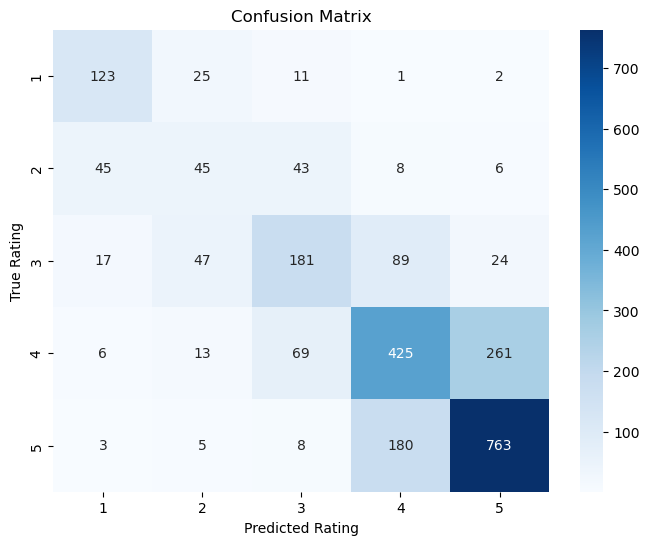

In [611]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=1, class_weight='balanced', 
                             solver='liblinear', penalty='l2',            
                             max_iter=10000, random_state=42
                             )

log_reg.fit(X_train_vec, y_train)
y_pred_lr = log_reg.predict(X_test_vec)
eval_metrics(y_test, y_pred_lr, "Normal Logistic Regression")

As expected, by looking at the classification matrix, the worst classified ratings seem to be 2 and 3. Much of this can be attributed to the fact that these fall the most amongst the "neutral" sentiment. While the same could be said about 4 in regards to neutrality, there a many more datapoints that are classed as a 4 rated review. This likely makes it much easier for the model to discern the certain texts as a 4. We can also see that despite not having many samples, the model did very well when classifying texts into class 1. This is once again likely due to those reviews containing very strong negative features, hence making them easier to classify.

We can test this model once again more comprehensively by performing 10-fold cross validation on it. This will let us better undrestand if this singular run might have been an anomaly or if logistic regression consistently performs well on our dataset.

Cross-Validation Scores (Stratified): [0.65001513 0.64100572 0.62088675 0.62866983 0.62706246 0.64301254
 0.64496312 0.63872512 0.63955272 0.63078044]
Mean Stratified CV Score: 0.6365 (±0.0087)
Logistic Regression with stratified K-fold validation
Accuracy: 0.6404
F1 score: 0.6350
F1 macro score: 0.5788
Mean Absolute Error: 0.4138
              precision    recall  f1-score   support

           1       0.64      0.75      0.69       162
           2       0.34      0.32      0.33       147
           3       0.58      0.51      0.54       358
           4       0.60      0.54      0.57       774
           5       0.72      0.80      0.76       959

    accuracy                           0.64      2400
   macro avg       0.58      0.58      0.58      2400
weighted avg       0.63      0.64      0.64      2400



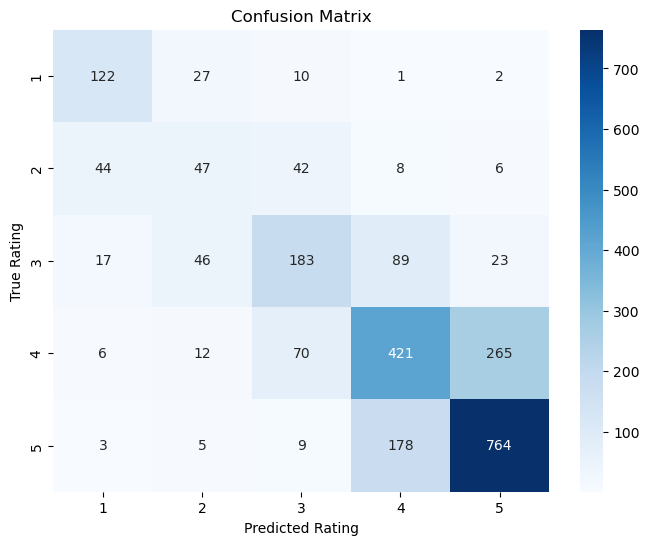

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), max_features=50000, min_df=5, max_df=0.8)),
    ('model', LogisticRegression(C=1, class_weight='balanced', 
                             solver='liblinear', penalty='l2',            
                             max_iter=10000, random_state=42
                             ))
])

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
stratified_cv_scores = cross_val_score(pipeline, lem_train_data["combined"], 
                                       lem_train_data["overall"], 
                                       cv=stratified_kfold, scoring='f1_weighted')

print(f"Cross-Validation Scores (Stratified): {stratified_cv_scores}")
print(f"Mean Stratified CV Score: {np.mean(stratified_cv_scores):.4f} (±{np.std(stratified_cv_scores):.4f})")

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

eval_metrics(y_test, y_pred, "Logistic Regression with stratified K-fold validation")

We can see that the model performs almost the exact same following 10 fold cross validation, indicating that it might be the furthest it can go regarding the current problem. As such, it might be time to look at more modern architectures. 

When concerning modern deep learning architectures, the model that seemed best poised to tackle this particular problem was the RoBERTa model (Liu et al., 2019) by researchers at the University of Washington. This is because RoBERTa acts as an extention of google's groundbreaking BERT model, elevating it further with extensive pre-training on a number of various topics. This makes it especially robust when compared to other models and very able at interpretating rich contextual texts such as reviews. The encoder-transformer architecture allows for the model to perform bi-directional context understanding of text, another feature which would make it very well fit for the current task.

The model was accessed through hugging face and utilised through the a number of supplemenentary hugging face libraries. These were understood through youtube videos referenced in the code next to their use. 

In [613]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import transformers 
from transformers import (
    RobertaTokenizer, 
    RobertaForSequenceClassification, 
    Trainer, 
    TrainingArguments,
    DataCollatorWithPadding
)

from datasets import Dataset

#importing the pretrained roberta model from hugging face
tokeniser =  RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels = 5
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [615]:
import torch
print("Torch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Torch version: 2.6.0+cu118
cuda


In [ ]:
class_counts = Counter(lem_train_data['overall'])
X_train, X_test, y_train, y_test = train_test_split(lem_train_data["combined"], 
                                                    lem_train_data["overall"], 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    shuffle=True)
print(len(X_train), len(X_test))

print("class counts")
for k,v in class_counts.items():
    print(f'{k} : {v}')

train_df = pd.DataFrame({'text': X_train, 'labels': y_train})
val_df = pd.DataFrame({'text': X_test, 'labels':y_test}) #we consider this the validation set before testing at the end of assignment

#HF dataset video: https://www.youtube.com/watch?v=_BZearw7f0w&ab_channel=HuggingFace
train_set = Dataset.from_pandas(train_df)
val_set = Dataset.from_pandas(val_df)

train_set.features

21598 2400
class counts
1 : 1557
4 : 7720
2 : 1611
3 : 3287
5 : 9823


{'text': Value(dtype='string', id=None),
 'labels': Value(dtype='int64', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [ ]:
#Hugging Face Tokeniser method: https://www.youtube.com/watch?v=0u3ioSwev3s&ab_channel=HuggingFace
def tokenise_data(data):
    return tokeniser(
        data['text'],
        truncation=True,
        max_length = 256, 
        padding='max_length',
    )

In [ ]:
train_set_tokens = train_set.map(tokenise_data, batched=True, remove_columns=(['text','__index_level_0__']))
val_set_tokens = val_set.map(tokenise_data, batched=True,  remove_columns=(['text','__index_level_0__']))

print(f"label of first training example before adjustment: {train_set_tokens[:1]['labels']}")

#labels adjusted to work with pytorch input format 
train_set_tokens = train_set_tokens.map(lambda x: {'labels': x['labels'] - 1}) 
val_set_tokens = val_set_tokens.map(lambda x: {'labels': x['labels'] - 1})

print(f"label of first training example after adjustment: {train_set_tokens[:1]['labels']}")
train_set_tokens.features

Map: 100%|██████████| 2400/2400 [00:01<00:00, 1789.79 examples/s]


label of first training example before adjustment: [5]


Map: 100%|██████████| 2400/2400 [00:00<00:00, 45274.08 examples/s]

label of first training example after adjustment: [4]


{'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [619]:
train_set_tokens.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_set_tokens.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_set_tokens

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 21598
})

In [620]:
def metrics(eva):
    preds, labels = eva
    preds = np.argmax(preds, axis=1)

    f1_weighted = f1_score(labels, preds, average='weighted')
    f1_macro = f1_score(labels, preds, average="macro")

    return {"weighted f1": f1_weighted, "macro f1": f1_macro}

In [ ]:
''' 
Hyper Paramerters were set in accordance to the RoBERTa paper. It is recommend to train the model for 1-3 epochs
as it likely would overfit given further epochs. This was tested and confirmed in previous draft versions (namely 9).
While warmup was 1000 steps in the paper, we use 600 steps here to account for compute without forgoing much compute.

Similarly a batch size of 32 was chosen in the best interest of compute. A learning rate of 5e-5 with weight decay of 1e-3
is considered standard practice and surprisingly led to the best results out of all the combinations tested.
'''
args = TrainingArguments(
    output_dir='./bert_robert',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate = 5e-5,
    lr_scheduler_type= "cosine",
    weight_decay=1e-3,
    warmup_steps= 600,
    eval_strategy='epoch',
    metric_for_best_model="weighted f1",
    load_best_model_at_end=True,
    save_strategy='epoch',
    save_total_limit=2,
)

#Hugging Face Trainer: https://www.youtube.com/watch?v=nvBXf7s7vTI&ab_channel=HuggingFace
trainer = Trainer(
    model = model, 
    args = args,
    train_dataset= train_set_tokens,
    eval_dataset = val_set_tokens,
    processing_class=tokeniser,
    data_collator=DataCollatorWithPadding(tokeniser),
    compute_metrics=metrics,
)

trainer.train()
trainer.save_model("./best_model")

Epoch,Training Loss,Validation Loss,Weighted f1,Macro f1
1,0.954100,0.766641,0.652075,0.612156
2,0.734700,0.744126,0.674001,0.621807
3,0.526400,0.764394,0.683911,0.641738


We can see here that RoBERTa significantly outperforms Logistic Regression and the other classical ML models. With a weighted F1 score of 0.68, it stands as a significant jump in performance compared to previous iterations. This follows expectations though it was expected to perform slightly better. Below in the classification report we can see exactly where the model improved. We can see that compared to logistic regression, RoBERTa performed much better at classifying class 2 reviews, with a weighted F1-score of 0.44 compared to 0.33 achieved by Logistic Regression. However, we still see some of the same issues present here that plagued the Logistic Regression model. We can see that the best performing classes are 1 and 5, while all the intermediate classes still aren't classified too accurately. 

In [622]:
predictions = trainer.predict(val_set_tokens)
preds = np.argmax(predictions.predictions, axis=1)

print(classification_report(
    val_set_tokens['labels'].numpy(),
    preds
))

              precision    recall  f1-score   support

           0       0.72      0.75      0.74       162
           1       0.46      0.43      0.44       147
           2       0.66      0.59      0.62       358
           3       0.62      0.61      0.62       774
           4       0.77      0.81      0.79       959

    accuracy                           0.69      2400
   macro avg       0.65      0.64      0.64      2400
weighted avg       0.68      0.69      0.68      2400



### 4. Experiment with VADER sentiment lexicon

Following the applciation of some supervised learning techniques on the data, we can test VADER, an unsupervised sentiment lexicon on our text data to see how it performs.

In [623]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

sentiment = SentimentIntensityAnalyzer()

def sentiment_scores(text):
    score = sentiment.polarity_scores(text)
    return score['compound']

lem_train_data.loc[:, 'vader_score'] = lem_train_data['combined'].apply(sentiment_scores)
lem_train_data


,overall,combined,vader_score
0,1,horrible experience first of all we get there ...,0.8192
1,1,stay away find racist graffiti in the room req...,-0.8225
2,4,great location and service close to union squa...,0.8479
3,2,I will never go back here again i have a bad v...,0.9418
4,1,rip off our visa card after departure after we...,0.4215
...,...,...,...
23994,4,pleasant stay with good location we stay just ...,0.9681
23995,3,hit or miss some thing need attention spend tw...,-0.8971
23996,5,good breakfast the room be fairly large pretty...,0.8689
23997,4,deserve a high rating great start to our stay ...,0.9682


In [ ]:
#Creating a vader score to class converter
def vader_classification(score):
    if score >= 0.7:
        return 5
    elif score > 0.3:
        return 4
    elif score > -0.3:
        return 3
    elif score >= -0.7:
        return 2
    else:
        return 1
    
lem_train_data.loc[:, 'vader_rating'] = lem_train_data['vader_score'].apply(vader_classification)
lem_train_data['vader_rating']
lem_train_data.loc[:, 'rating_discrepancy'] = abs(lem_train_data['overall'] - lem_train_data['vader_rating'])
lem_train_data

,overall,combined,vader_score,vader_rating,rating_discrepancy
0,1,horrible experience first of all we get there ...,0.8192,5,4
1,1,stay away find racist graffiti in the room req...,-0.8225,1,0
2,4,great location and service close to union squa...,0.8479,5,1
3,2,I will never go back here again i have a bad v...,0.9418,5,3
4,1,rip off our visa card after departure after we...,0.4215,4,3
...,...,...,...,...,...
23994,4,pleasant stay with good location we stay just ...,0.9681,5,1
23995,3,hit or miss some thing need attention spend tw...,-0.8971,1,2
23996,5,good breakfast the room be fairly large pretty...,0.8689,5,0
23997,4,deserve a high rating great start to our stay ...,0.9682,5,1


In [625]:
mean_discrepancy = lem_train_data['rating_discrepancy'].mean()
print(f"The average discrepancy between vader sentiment rating based on text and ground truth rating given by customer is: {mean_discrepancy:.4f}")

The average discrepancy between vader sentiment rating based on text and ground truth rating given by customer is: 0.7870


From these results we can see that VADER performs very poorly on our data especially when compared to the supervised learning methods already shown. We also notice that unlike the supervised learning models, VADER performs terribly on classifying reviews as rating 4. This is very odd given the large number of data points to support it. But by looking at the confusion matrix, it becomes quite evident why VADER performed so poorly. Likely due to heavy class imbalance, it heavily swayed most ratings to explicitly be very positive. This mean that the majority of ratings that should have been either a 3 or 4 were classed as heavily positive due to the presence of some positive sounding words in their body.

accuracy: 0.4579
precision: 0.3765
recall: 0.4579
f1_weighted: 0.3425
              precision    recall  f1-score   support

           1       0.56      0.43      0.49      1557
           2       0.29      0.11      0.16      1611
           3       0.31      0.07      0.12      3287
           4       0.26      0.04      0.07      7720
           5       0.47      0.98      0.64      9823

    accuracy                           0.46     23998
   macro avg       0.38      0.33      0.30     23998
weighted avg       0.38      0.46      0.34     23998



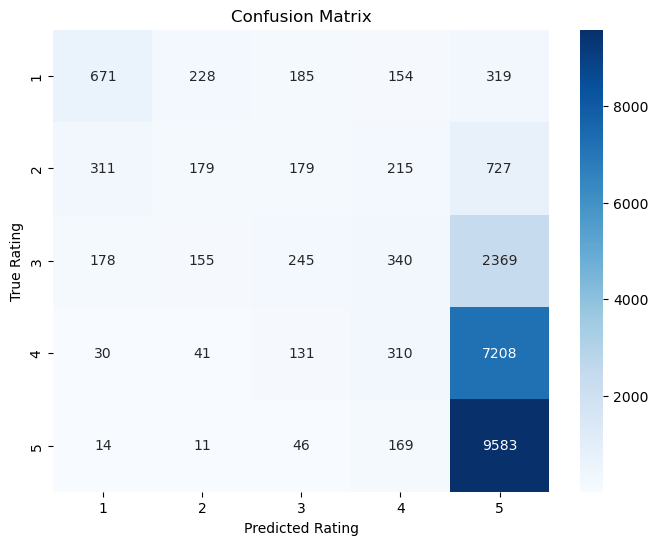

In [626]:
y_true, y_pred = lem_train_data['overall'], lem_train_data['vader_rating']

accuracy = accuracy_score(y_true, y_pred)
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f'accuracy: {accuracy:.4f}')
print(f'precision: {precision_weighted:.4f}')
print(f'recall: {recall_weighted:.4f}')
print(f'f1_weighted: {f1_weighted:.4f}')

print(classification_report(y_true, y_pred))

con_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

Though VADER by itself doesnt perform too well, there could be ways to leverage VADER to improve our current best deep learning model. While there could have been a few ways to go about this, including potential RLHF with inaccurate vs accurate VADER scores, the easiest method was to consider the VADER scores of the review as an additonal feature alongside the text content. We can do this by finetuning RoBERTa to have an additional output layer that considers the VADER scores as part of its evaluation metric. While this sounds promising, the heavy inaccuracy of the VADER scores could potentially cause some issues in the evaluation. 

Trying to combine both vader and RoBERTa

In [ ]:
#Adjsut the vader return to account for all vader calculations as these will count as features now
def sentiment_scores(text):
    score = sentiment.polarity_scores(text)
    return [score['pos'], score['neu'], score['neg']] #Compound score is excluded so that the raw sentiment scores are the only features

train_df['vader_features'] = train_df['text'].apply(sentiment_scores)
val_df['vader_features'] = val_df['text'].apply(sentiment_scores)

train_df.head()

,text,labels,vader_features
10673,not bad a great location outside of downtown o...,5,"[0.103, 0.798, 0.099]"
1034,nice hotel if you can get a good rate stay her...,4,"[0.338, 0.662, 0.0]"
10657,clean excellent location safe perfect location...,5,"[0.208, 0.733, 0.059]"
725,nice hotel but work hard to charge for little ...,3,"[0.224, 0.68, 0.096]"
23181,good hotel sketchy location we stay here for j...,4,"[0.269, 0.651, 0.08]"


In [628]:
train_set_vader = Dataset.from_pandas(train_df)
val_set_vader = Dataset.from_pandas(val_df)

train_set_vader.features

{'text': Value(dtype='string', id=None),
 'labels': Value(dtype='int64', id=None),
 'vader_features': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [ ]:
train_vader_tokens = train_set_vader.map(tokenise_data, batched=True, remove_columns=['text','__index_level_0__'])
val_vader_tokens = val_set_vader.map(tokenise_data, batched=True, remove_columns=['text','__index_level_0__'])

print(f"label of first training example before adjustment: {train_vader_tokens[:1]['labels']}")

#labels adjusted to work with pytorch input format 
train_vader_tokens = train_vader_tokens.map(lambda x: {'labels': x['labels'] - 1})
val_vader_tokens = val_vader_tokens.map(lambda x: {'labels': x['labels'] - 1})

print(f"label of first training example after adjustment: {train_vader_tokens[:1]['labels']}")
train_vader_tokens.features

Map: 100%|██████████| 2400/2400 [00:01<00:00, 1738.22 examples/s]


label of first training example before adjustment: [5]


Map: 100%|██████████| 2400/2400 [00:00<00:00, 34538.31 examples/s]

label of first training example after adjustment: [4]


{'labels': Value(dtype='int64', id=None),
 'vader_features': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [630]:
train_vader_tokens.set_format(type = 'torch')
val_vader_tokens.set_format(type = 'torch')

train_vader_tokens.features

{'labels': Value(dtype='int64', id=None),
 'vader_features': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [631]:
from transformers import RobertaConfig 
from transformers.modeling_outputs import SequenceClassifierOutput
#we re-init a new instance of the RoBERTa model and expand its implementation to include the additional new features

class RobertaVader(RobertaForSequenceClassification):
    def __init__(self, config: RobertaConfig):
        super().__init__(config)

        self.vader_linear = nn.Linear(3, 16)
        self.dropout = nn.Dropout(0.5)

        self.out = nn.Linear(config.hidden_size + 16, config.num_labels)
    
    def forward(self, input_ids=None, attention_mask=None, labels=None, vader_features=None, **kwargs):
        
        kwargs.pop('num_items_in_batch', None) #Bug fix found on https://github.com/huggingface/transformers/issues/35838
        
        outs = self.roberta(
            input_ids = input_ids,
            attention_mask = attention_mask,
            **kwargs
        )
        
        sequence_output = outs[0]
        pooled_out = sequence_output[:, 0, :]

        if vader_features is None:
            vader_features = torch.zeros(input_ids.size(0), 4, device=input_ids.device)

        vader_embd = self.vader_linear(vader_features.float())
        vader_embd = self.dropout(vader_embd)

        output = torch.cat((pooled_out, vader_embd), dim=1)
        output = self.dropout(output)

        logits = self.out(output)

        loss = None
        if labels is not None:
            criterion = nn.CrossEntropyLoss()
            loss = criterion(logits, labels)
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=None,
            attentions=None
        )


In [632]:
#Code template for this generated using Claude 3.7 Sonnet and adjusted to dataset
class VaderDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        features_copy = [{k: v for k, v in f.items() if k != "vader_features"} for f in features]
        
        batch = super().__call__(features_copy)
        
        vader_features = []
        for f in features:
            vf = f["vader_features"]
            if isinstance(vf, torch.Tensor):
                vader_features.append(vf.tolist())
            elif isinstance(vf, np.ndarray):
                vader_features.append(vf.tolist())
            else:
                vader_features.append(vf)
                
        batch["vader_features"] = torch.tensor(vader_features, dtype=torch.float)
        
        return batch

In [ ]:
config = RobertaConfig.from_pretrained(
    'roberta-base',
    num_labels=5
)

model = RobertaVader.from_pretrained("roberta-base", config=config)
data_collator = VaderDataCollator(tokeniser)

#We train with the same configuration as the initial RoBERTa model
args = TrainingArguments(
    output_dir='./bert_robert_vader',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate = 5e-5,
    lr_scheduler_type= "cosine",
    weight_decay=1e-3,
    warmup_steps= 600,
    eval_strategy='epoch',
    metric_for_best_model="weighted f1",
    load_best_model_at_end=True,
    save_strategy='epoch',
    save_total_limit=2,
)

trainer = Trainer(
    model = model, 
    args = args,
    train_dataset= train_vader_tokens,
    eval_dataset = val_vader_tokens,
    processing_class=tokeniser,
    data_collator=data_collator,
    compute_metrics=metrics,
)

trainer.train()
trainer.save_model("./best_model_vader")

Some weights of RobertaVader were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'out.bias', 'out.weight', 'vader_linear.bias', 'vader_linear.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted f1,Macro f1
1,0.997000,0.778031,0.655796,0.611969
2,0.755500,0.727138,0.674209,0.629003
3,0.547100,0.767390,0.682680,0.639552


In [634]:
predictions = trainer.predict(val_vader_tokens)
preds = np.argmax(predictions.predictions, axis=1)

print(classification_report(
    val_vader_tokens['labels'].numpy(),
    preds
))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       162
           1       0.44      0.44      0.44       147
           2       0.66      0.56      0.61       358
           3       0.63      0.60      0.61       774
           4       0.76      0.82      0.79       959

    accuracy                           0.69      2400
   macro avg       0.64      0.64      0.64      2400
weighted avg       0.68      0.69      0.68      2400



Surprisingly, the model with the additonal VADER features performs almost exactly the same as the original model. 

### 5. Final testing on test set and discussion of results

In [635]:
test_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“I was SO surprised! I WILL return!”,My husband and I just celebrated our 25th wedd...,"{'username': 'shooflyfarm', 'num_cities': 15, ...",November 2011,1783324,1,2011-11-26,121063682,False,I was SO surprised I WILL return,My husband and I just celebrated our 25th wedd...
1,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“A Mother/Daughter vacation”,I could not leave a bad comment on any part of...,"{'username': 'bestmpm', 'num_reviews': 1, 'id'...",August 2011,88458,0,2011-08-10,116545869,False,A MotherDaughter vacation,I could not leave a bad comment on any part of...
2,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Good Choice for Pre-cruise”,I spent one night at this hotel prior to a cru...,"{'username': 'Conner2dood', 'num_cities': 20, ...",November 2010,82868,0,2010-12-06,89196759,False,Good Choice for Precruise,I spent one night at this hotel prior to a cru...
3,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“Unsung Hero”,"For the past year and a half, my daughter has ...","{'username': 'LeviK', 'num_reviews': 2, 'num_c...",July 2011,98979,0,2011-07-28,115879719,False,Unsung Hero,For the past year and a half my daughter has b...
4,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Great Value for a King, Queen, and Princesses.”","Great Value for a King, Queen, and Princesses....","{'username': 'thomrho', 'num_cities': 13, 'num...",March 2007,112273,8,2007-03-21,7198417,False,Great Value for a King Queen and Princesses,Great Value for a King Queen and Princesses We...
...,...,...,...,...,...,...,...,...,...,...,...,...
5995,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Felt right at home here”,I've stayed at many downtown Chicago hotels. T...,"{'username': 'eyemdphd', 'num_cities': 9, 'num...",April 2012,217498,3,2012-05-01,129203990,False,Felt right at home here,Ive stayed at many downtown Chicago hotels Thi...
5996,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Days Inn Chicago 101212”,It is always a pleasant stay at your facility....,"{'username': 'ROBERT S', 'num_reviews': 1, 'id...",October 2012,87571,0,2012-10-22,143435143,False,Days Inn Chicago 101212,It is always a pleasant stay at your facility ...
5997,"{'service': 2.0, 'cleanliness': 3.0, 'overall'...",“Upgrades Needed”,We recently stayed here for a girls' weekend. ...,"{'username': 'Daisy M', 'num_reviews': 1, 'id'...",January 2012,223022,0,2012-01-30,123834976,False,Upgrades Needed,We recently stayed here for a girls weekend Th...
5998,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“perfect bargain city hotel”,I made my reservation online at the Bijou beca...,"{'username': 'doublemet', 'num_reviews': 1, 'i...",May 2010,80920,1,2010-05-30,65827506,False,perfect bargain city hotel,I made my reservation online at the Bijou beca...


In [636]:
test_data['lemmatized_text'] = lemmatize(test_data['clean_text'])
test_data['lemmatized_text']

0       my husband and I just celebrate our 25th weddi...
1       I could not leave a bad comment on any part of...
2       I spend one night at this hotel prior to a cru...
3       for the past year and a half my daughter have ...
4       Great Value for a King Queen and Princesses we...
                              ...                        
5995    I ve stay at many downtown Chicago hotel this ...
5996    it be always a pleasant stay at your facility ...
5997    we recently stay here for a girl weekend the s...
5998    I make my reservation online at the Bijou beca...
5999    I stay at the Palmer House Hilton to attend th...
Name: lemmatized_text, Length: 6000, dtype: object

In [637]:
test_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text,lemmatized_text
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“I was SO surprised! I WILL return!”,My husband and I just celebrated our 25th wedd...,"{'username': 'shooflyfarm', 'num_cities': 15, ...",November 2011,1783324,1,2011-11-26,121063682,False,I was SO surprised I WILL return,My husband and I just celebrated our 25th wedd...,my husband and I just celebrate our 25th weddi...
1,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“A Mother/Daughter vacation”,I could not leave a bad comment on any part of...,"{'username': 'bestmpm', 'num_reviews': 1, 'id'...",August 2011,88458,0,2011-08-10,116545869,False,A MotherDaughter vacation,I could not leave a bad comment on any part of...,I could not leave a bad comment on any part of...
2,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Good Choice for Pre-cruise”,I spent one night at this hotel prior to a cru...,"{'username': 'Conner2dood', 'num_cities': 20, ...",November 2010,82868,0,2010-12-06,89196759,False,Good Choice for Precruise,I spent one night at this hotel prior to a cru...,I spend one night at this hotel prior to a cru...
3,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“Unsung Hero”,"For the past year and a half, my daughter has ...","{'username': 'LeviK', 'num_reviews': 2, 'num_c...",July 2011,98979,0,2011-07-28,115879719,False,Unsung Hero,For the past year and a half my daughter has b...,for the past year and a half my daughter have ...
4,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Great Value for a King, Queen, and Princesses.”","Great Value for a King, Queen, and Princesses....","{'username': 'thomrho', 'num_cities': 13, 'num...",March 2007,112273,8,2007-03-21,7198417,False,Great Value for a King Queen and Princesses,Great Value for a King Queen and Princesses We...,Great Value for a King Queen and Princesses we...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Felt right at home here”,I've stayed at many downtown Chicago hotels. T...,"{'username': 'eyemdphd', 'num_cities': 9, 'num...",April 2012,217498,3,2012-05-01,129203990,False,Felt right at home here,Ive stayed at many downtown Chicago hotels Thi...,I ve stay at many downtown Chicago hotel this ...
5996,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Days Inn Chicago 101212”,It is always a pleasant stay at your facility....,"{'username': 'ROBERT S', 'num_reviews': 1, 'id...",October 2012,87571,0,2012-10-22,143435143,False,Days Inn Chicago 101212,It is always a pleasant stay at your facility ...,it be always a pleasant stay at your facility ...
5997,"{'service': 2.0, 'cleanliness': 3.0, 'overall'...",“Upgrades Needed”,We recently stayed here for a girls' weekend. ...,"{'username': 'Daisy M', 'num_reviews': 1, 'id'...",January 2012,223022,0,2012-01-30,123834976,False,Upgrades Needed,We recently stayed here for a girls weekend Th...,we recently stay here for a girl weekend the s...
5998,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“perfect bargain city hotel”,I made my reservation online at the Bijou beca...,"{'username': 'doublemet', 'num_reviews': 1, 'i...",May 2010,80920,1,2010-05-30,65827506,False,perfect bargain city hotel,I made my reservation online at the Bijou beca...,I make my reservation online at the Bijou beca...


In [ ]:
#applying same data cleaning and formatting on test set as train set
test_data['lemmatized_text'] = test_data['lemmatized_text'].apply(lambda x: x.lower())
test_data['clean_title'] = test_data['clean_title'].apply(lambda x: x.lower())

In [639]:
test_data['clean_title'] = lemmatize(test_data['clean_title'])
test_data['overall'] = test_data['ratings'].apply(get_overall)
test_data['overall']
test_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text,lemmatized_text,overall
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“I was SO surprised! I WILL return!”,My husband and I just celebrated our 25th wedd...,"{'username': 'shooflyfarm', 'num_cities': 15, ...",November 2011,1783324,1,2011-11-26,121063682,False,I be so surprised I will return,My husband and I just celebrated our 25th wedd...,my husband and i just celebrate our 25th weddi...,5
1,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“A Mother/Daughter vacation”,I could not leave a bad comment on any part of...,"{'username': 'bestmpm', 'num_reviews': 1, 'id'...",August 2011,88458,0,2011-08-10,116545869,False,a motherdaughter vacation,I could not leave a bad comment on any part of...,i could not leave a bad comment on any part of...,5
2,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Good Choice for Pre-cruise”,I spent one night at this hotel prior to a cru...,"{'username': 'Conner2dood', 'num_cities': 20, ...",November 2010,82868,0,2010-12-06,89196759,False,good choice for precruise,I spent one night at this hotel prior to a cru...,i spend one night at this hotel prior to a cru...,4
3,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“Unsung Hero”,"For the past year and a half, my daughter has ...","{'username': 'LeviK', 'num_reviews': 2, 'num_c...",July 2011,98979,0,2011-07-28,115879719,False,unsung hero,For the past year and a half my daughter has b...,for the past year and a half my daughter have ...,5
4,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Great Value for a King, Queen, and Princesses.”","Great Value for a King, Queen, and Princesses....","{'username': 'thomrho', 'num_cities': 13, 'num...",March 2007,112273,8,2007-03-21,7198417,False,great value for a king queen and princess,Great Value for a King Queen and Princesses We...,great value for a king queen and princesses we...,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Felt right at home here”,I've stayed at many downtown Chicago hotels. T...,"{'username': 'eyemdphd', 'num_cities': 9, 'num...",April 2012,217498,3,2012-05-01,129203990,False,feel right at home here,Ive stayed at many downtown Chicago hotels Thi...,i ve stay at many downtown chicago hotel this ...,5
5996,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Days Inn Chicago 101212”,It is always a pleasant stay at your facility....,"{'username': 'ROBERT S', 'num_reviews': 1, 'id...",October 2012,87571,0,2012-10-22,143435143,False,day inn chicago 101212,It is always a pleasant stay at your facility ...,it be always a pleasant stay at your facility ...,5
5997,"{'service': 2.0, 'cleanliness': 3.0, 'overall'...",“Upgrades Needed”,We recently stayed here for a girls' weekend. ...,"{'username': 'Daisy M', 'num_reviews': 1, 'id'...",January 2012,223022,0,2012-01-30,123834976,False,upgrade need,We recently stayed here for a girls weekend Th...,we recently stay here for a girl weekend the s...,2
5998,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“perfect bargain city hotel”,I made my reservation online at the Bijou beca...,"{'username': 'doublemet', 'num_reviews': 1, 'i...",May 2010,80920,1,2010-05-30,65827506,False,perfect bargain city hotel,I made my reservation online at the Bijou beca...,i make my reservation online at the bijou beca...,5


In [640]:
test_data_ref = test_data[['overall', 'clean_title','lemmatized_text']]
test_data_ref['combined'] = test_data_ref['clean_title'] + ' ' + test_data_ref['lemmatized_text']
test_data_ref

,overall,clean_title,lemmatized_text,combined
0,5,I be so surprised I will return,my husband and i just celebrate our 25th weddi...,I be so surprised I will return my husband and...
1,5,a motherdaughter vacation,i could not leave a bad comment on any part of...,a motherdaughter vacation i could not leave a ...
2,4,good choice for precruise,i spend one night at this hotel prior to a cru...,good choice for precruise i spend one night at...
3,5,unsung hero,for the past year and a half my daughter have ...,unsung hero for the past year and a half my da...
4,5,great value for a king queen and princess,great value for a king queen and princesses we...,great value for a king queen and princess grea...
...,...,...,...,...
5995,5,feel right at home here,i ve stay at many downtown chicago hotel this ...,feel right at home here i ve stay at many down...
5996,5,day inn chicago 101212,it be always a pleasant stay at your facility ...,day inn chicago 101212 it be always a pleasant...
5997,2,upgrade need,we recently stay here for a girl weekend the s...,upgrade need we recently stay here for a girl ...
5998,5,perfect bargain city hotel,i make my reservation online at the bijou beca...,perfect bargain city hotel i make my reservati...


In [641]:
test_data_df = test_data_ref[['overall', 'combined']]

During intital test run an error was found regarding the tokenisation process. Though this error presents itself as a cuda error, in reality it refers to label data not being in the expected 0-indexed pytorch form. As such, exploration was conducted to find the data points causing this error.

In [642]:
negative = (test_data_df['overall'] <= 0).any()
negative

True

In [643]:
counts_below = (test_data_df['overall'] <= 0).sum()
counts_below

1

In [644]:
if counts_below > 0:
    neg = test_data_df[test_data_df['overall'] <= 0]

print(neg)

      overall                                           combined
5960        0  perfect location large room stay for two week ...


In [645]:
test_data_df = test_data_df[test_data_df['overall'] > 0]

In [646]:
# train_set = Dataset.from_pandas(lem_train_data)
test_set = Dataset.from_pandas(test_data_df)

train_set, test_set

(Dataset({
     features: ['text', 'labels', '__index_level_0__'],
     num_rows: 21598
 }),
 Dataset({
     features: ['overall', 'combined', '__index_level_0__'],
     num_rows: 5999
 }))

In [647]:
# train_set = train_set.rename_column('overall', 'labels')
test_set = test_set.rename_column('overall', 'labels')
test_set

Dataset({
    features: ['labels', 'combined', '__index_level_0__'],
    num_rows: 5999
})

In [648]:
def tokenise_data(data):
    return tokeniser(
        data['combined'],
        truncation=True,
        max_length = 256, 
        padding='max_length',
    )

test_set_tokens = test_set.map(tokenise_data, batched=True,  remove_columns=(['combined', '__index_level_0__']))

print(f"label of first test example before adjustment: {test_set_tokens[:1]['labels']}")

test_set_tokens = test_set_tokens.map(lambda x: {'labels': x['labels'] - 1})

print(f"label of first test example after adjustment: {train_set_tokens[:1]['labels']}")
test_set_tokens

Map: 100%|██████████| 5999/5999 [00:03<00:00, 1775.41 examples/s]


label of first test example before adjustment: [5]


Map: 100%|██████████| 5999/5999 [00:00<00:00, 53833.18 examples/s]

label of first test example after adjustment: tensor([4])


Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 5999
})

In [649]:
test_set_tokens.set_format(type='torch')
test_set_tokens['labels'].min(), test_set_tokens['labels'].max()

(tensor(0), tensor(4))

In [ ]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#loading in the best trained model (without VADER)
model = RobertaForSequenceClassification.from_pretrained("./best_model", num_labels=5)

test_args = TrainingArguments(
    per_device_eval_batch_size=16,
    
)

test_trainer = Trainer(
    model=model,
    args=test_args,
    processing_class = tokeniser,
    compute_metrics=metrics,
)

# Now you can evaluate on your test set
test_results = test_trainer.evaluate(test_set_tokens)
print(f"Test results: {test_results}")


Test results: {'eval_loss': 0.7411855459213257, 'eval_model_preparation_time': 0.0014, 'eval_weighted f1': 0.6948633497879794, 'eval_macro f1': 0.652783332788253, 'eval_runtime': 13.19, 'eval_samples_per_second': 454.815, 'eval_steps_per_second': 28.431}


In [651]:
test_results

{'eval_loss': 0.7411855459213257,
 'eval_model_preparation_time': 0.0014,
 'eval_weighted f1': 0.6948633497879794,
 'eval_macro f1': 0.652783332788253,
 'eval_runtime': 13.19,
 'eval_samples_per_second': 454.815,
 'eval_steps_per_second': 28.431}

Following testing, we can see that the model actually performed better on the test set than on the validation set. These results indicate that the model generalises effectively to new data and provides consistently improved performance across the different classes on the test set. We can see here that class 5 actually had a weighted f1 score 0.8, a benchmark that was as of yet, not reached by any of the previous tests. The overall accuracy of the model as broke the 70% barrier though it was not the primary evaluation metric. However the weighted f1 score of 0.6948 almost did infact break the 70% barrier. We can take these as very solid results for the current experiment, though with more compute and research, these could have been even more optimised. Especially on the more neutral sentiment classes like 2 and 3. 

In [652]:
predictions = test_trainer.predict(test_set_tokens)
preds = np.argmax(predictions.predictions, axis=1)

print(classification_report(
    test_set_tokens['labels'].numpy(),
    preds
))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       385
           1       0.51      0.46      0.48       420
           2       0.61      0.56      0.58       793
           3       0.64      0.65      0.64      1933
           4       0.79      0.81      0.80      2468

    accuracy                           0.70      5999
   macro avg       0.66      0.65      0.65      5999
weighted avg       0.69      0.70      0.69      5999



### 7. Reflection on the ***Product*** development.

Applied Natural Language Processing Assignment 1: Reflection
a1797378: Arpan Mukhopadhyay
git repo: https://github.com/ArpanMukhopadhyay/NLP_applied/tree/main/assignment1 

Data pre-processing and Exploratory Data Analysis

Data pre-processing and Exploratory Data Analysis (EDA) were the tasks that comprised most of the initial drafts. In-built functions from the python standard library alongside pandas pd.read_json()were used to extract and convert the given dataset. Non-English reviews were removed using the provided language_filter.py file, which only removed one review. Notably, the function was adjusted to only check the language of the text content of the review and not the title. Both title and text were tested though applying the function on the title column surprisingly led to several false positives, leading to many English reviews being removed. As such, this check was applied only to the reviews. 

While further revisions took a more refined approach to the extraction and analysis of the primary evaluation terms (‘overall’, ‘title’, ‘text’), initial exploratory syntax was rather convoluted. This stemmed from my initial misunderstanding of the task, where I believed we were to consider all the ratings as part of the ‘overall’. This led to me accessing the entire ratings dictionary and developing visualisations regarding each of the rating types. While useful for a broader task, these proved useless for the current task and were removed in version 4. This also led to the discovery of the heavily imbalanced nature of the dataset. Though initial resampling methods were considered, the approach to this issue was taken on a ‘per-model basis’.
 
As a baseline, all text was cleaned to remove non-alphanumeric characters and extra white space characters. Lowercasing was applied on a per-case basis for visualisation purposes before being permanently applied to the dataset prior model training. Regarding lemmatization and stemming (version 4), lemmatisation was chosen as words following lemmatization carry stronger contextual clues towards sentiment compared to stemming, which could better help discern the valence and/or arousal of sentiments. Though it was utilised for many versions, model performance was found to be negatively affected by stop-word removal. This was likely due to stop words occasionally altering the sentiment of a phrase (“not good” vs “good”).

Machine Learning

The machine learning portion of the assignment involved much experimentation. Initially, four different classical machine learning models were chosen. Multinomial Naïve Bayes, SVM, Logistic Regression and Decision Trees. Given the initial heavily imbalanced and high dimensional nature of the dataset, it was assumed that Random Forest with Decision trees or SVM would perform best. Random forest thanks to its ability to generalise well to imbalanced datasets and SVM thanks to its inherent ability to deal with high dimensional data. However, Random Forest performed quite poorly, I’m still not sure why. SVM on the other hand was a strange case as it performed differently based on which Sklearn library was used. While the standard SVC() library with kernel='linear' yielded results similar to the Logistic Regression model, it took an awfully long time to run (approximately 2-3 minutes). However, the LinearSVC() model, which ran an SVM model with an explicit Linear Kernel function ran much faster but performed slightly worse. This was an odd tradeoff to consider but given the computationally efficiency of LinearSVC, it was chosen as the SVM model of choice. And since it performed notably worse than the Logistic regression model, it was not chosen as the classical model of choice.

Experimentation with SMOTE was also undertaken in regards to dealing with the imbalanced dataset though it only proved to be useful when applied to the Multinomial Naive Bayes model. However, even with SMOTE this MNB performed worse than Logistic Regression and both implementations of SVM. This experimentation can be seen throughout most revisions especially versions 6-9. Word embeddings were tested though my virtual environment had issues loading external models like GloVe. There were experiments with spacy's word vectors though the results were much, much worse than any of the TF-IDF implementations. However given other circumstances, I would attempt to utilise these other word embeddings models. 

In regards to the deep learning model, the data was first tested against a very simple mlp neural network. This was a simple experiment to see how even the most basic of deep learning models would compete against the more classic models. Initial overfitting was expected due to the high dimensionality of the data but this was adjusted using heavy dropout and batchnorm. The final simple neural network achieved accuracy scores of approximately 0.62 which outperformed quite a few of the classical ML models. Refer to revision 8 and 9 to see this. 

For the usage of RoBERTa, much of it was developed using Hugging Face tutorials as reference and the models supporting research paper. Much of this section involved trial and error to select the best hyper parameters. Under other circumstances this particular process could have been much more streamlined through additonal tools such as GridSearch for the learning rate though the use of tooling like MLFlow would prove ideal. 

Finally in terms of using VADER as a supplementary tool, my initial idea was to use VADER in a way similar to Reinforcement Learning with Human Feedback (RLHF), using the correct VADER classifications to correct incorrect model classifications. However the poor initial performance of VADER alongisde the potential complexity of the implementation of this method detracted me from this idea. As such, the much simpler choice of using VADER as an additional feature was chosen. This, though relatively simple comparatively, unveiled a sense of hidden complexity which required me to refer to claude 3.7 Sonnet to assist with some persistent bugs in the implementation. This was by far the most time consuming part of the assignment. Given more time, resources and personal intellect, i would experiment more with using VADER's additional features to improve classification. Though i do think the final result of a 0.7 accuracy and 0.69 weighted F1 on the test set is quite solid given the intial dataset. 

### 9. References

Bi-Min Hsu. “Comparison of Supervised Classification Models on Textual Data.” Mathematics 8(5):851, 2020.

Chawla, N.V., Bowyer, K.W., Hall, L.O. and Kegelmeyer, W.P. (2002) 'SMOTE: Synthetic Minority Over-sampling Technique', Journal of Artificial Intelligence Research, 16, pp. 321–357. doi: 10.1613/jair.953.

Liu, Y., Ott, M., Goyal, N., Du, J., Joshi, M., Chen, D., Levy, O., Lewis, M., Zettlemoyer, L. and Stoyanov, V. (2019) 'RoBERTa: A Robustly Optimized BERT Pretraining Approach'

### Appendix